#Regina Aprilia Roberto
#Submission Image Classification 
Dataset: https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar?select=Dataset

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
import pathlib

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kancingkuning","key":"d5091e2a766c94e0e0f6d205d1dda094"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d abtabm/multiclassimagedatasetairplanecar

 99% 330M/333M [00:02<00:00, 178MB/s]
100% 333M/333M [00:02<00:00, 123MB/s]


In [6]:
!unzip /content/multiclassimagedatasetairplanecar -d /content

Archive:  /content/multiclassimagedatasetairplanecar.zip
  inflating: /content/Dataset/test/airplanes/airplane1.jpg  
  inflating: /content/Dataset/test/airplanes/airplane10.jpg  
  inflating: /content/Dataset/test/airplanes/airplane100.jpg  
  inflating: /content/Dataset/test/airplanes/airplane101.jpg  
  inflating: /content/Dataset/test/airplanes/airplane102.jpg  
  inflating: /content/Dataset/test/airplanes/airplane103.jpg  
  inflating: /content/Dataset/test/airplanes/airplane104.jpg  
  inflating: /content/Dataset/test/airplanes/airplane105.jpg  
  inflating: /content/Dataset/test/airplanes/airplane106.jpg  
  inflating: /content/Dataset/test/airplanes/airplane107.jpg  
  inflating: /content/Dataset/test/airplanes/airplane108.jpg  
  inflating: /content/Dataset/test/airplanes/airplane109.jpg  
  inflating: /content/Dataset/test/airplanes/airplane11.jpg  
  inflating: /content/Dataset/test/airplanes/airplane110.jpg  
  inflating: /content/Dataset/test/airplanes/airplane111.jpg  
  

In [7]:
base_dir = '/content/Dataset/train'
total_image = len(list(glob.iglob("/content/Dataset/train/*/*.*", recursive=True)))
print("Total all image train: ",total_image)

Total all image train:  3000


In [8]:
ship_dir = os.path.join('/content/Dataset/train/ship')
car_dir = os.path.join('/content/Dataset/train/cars')
airplanes_dir = os.path.join('/content/Dataset/train/airplanes')

In [9]:
total_image = len(list(glob.iglob("/content/Dataset/train/*/*.*", recursive=True)))
print("Total all image: ",total_image)

total_ship = len(os.listdir(ship_dir))
total_car = len(os.listdir(car_dir))
total_airplane = len(os.listdir(airplanes_dir))

# Mencetak jumlah data rock paper scissor
print("Ship: ",total_ship)
print("Car: ",total_car)
print("Airplane: ",total_airplane)

Total all image:  3000
Ship:  1000
Car:  1000
Airplane:  1000


In [10]:
def rules():
  rotation_range = 30
  brightness_range = [0.2, 1.0]
  shear_range = 0.2
  zoom_range = 0.2
  horizontal_flip = True
  fill_mode = 'nearest'
  rescale = 1./255
  return rules

In [17]:
w = 150
h = 150
train_datagen = ImageDataGenerator(rules, validation_split = 0.2)
train_set = train_datagen.flow_from_directory(
    base_dir,
    target_size = (w, h),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)
validation_datagen = ImageDataGenerator(rules, validation_split = 0.2)
validation_set = validation_datagen.flow_from_directory(
    base_dir,
    target_size = (w, h),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False,
    subset = "validation"
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [13]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(150, 150, 3),
                                                include_top=False,
                                                weights="imagenet")
for layer in pre_trained_model.layers:
  layer.trainable = False

add_layer = pre_trained_model.get_layer('block5_pool')
add_output = add_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(add_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
Adam(learning_rate = 0.0001, name='Adam')
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
      print('stop training')
      self.model.stop_training = True

callbacks = myCallback()

In [21]:
epochs = 10

history = model.fit(train_set,
                    epochs=epochs,
                    validation_data=validation_set,
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
75/75 [==============================] - 737s 10s/step - loss: 4.5028 - accuracy: 0.9271 - val_loss: 0.3773 - val_accuracy: 0.9900
Epoch 2/10
75/75 [==============================] - 722s 10s/step - loss: 0.6418 - accuracy: 0.9792 - val_loss: 0.0977 - val_accuracy: 0.9950


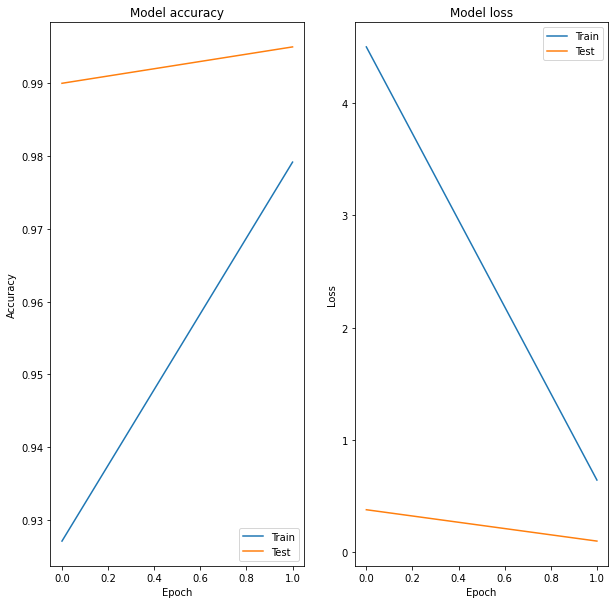

In [22]:
akurasi = history.history['accuracy']
val_acc = history.history['val_accuracy']

range_epochs = range(2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range_epochs, akurasi, val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(range_epochs, loss, val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [23]:
model.save("model.h5")

In [24]:
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model);